In [43]:
import os
os.environ['TF_NUM_INTRAOP_THREADS'] = '4'  # Optimize CPU thread usage
os.environ['TF_NUM_INTEROP_THREADS'] = '8'

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.cluster import KMeans


In [44]:
np.random.seed(42)
tf.random.set_seed(42)

# Disable GPU (force CPU usage)
tf.config.set_visible_devices([], 'GPU')
print("GPU disabled. Training will use CPU.")

data = pd.read_csv('cleaned_data.csv')
print(f"Initial records: {len(data)}")
data.columns = data.columns.str.replace(' ', '_')
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)


GPU disabled. Training will use CPU.
Initial records: 15269


In [ ]:
def engineer_features(df, train_df=None):
    df['Price_log'] = np.log1p(df['Price'])
    for col in ['Land_size', 'House_size']:
        df[f'{col}_log'] = np.log1p(df[col])
    df['size_ratio'] = df['House_size_log'] / (df['Land_size_log'] + 1e-5)
    df['size_diff'] = df['Land_size_log'] - df['House_size_log']
    
    # Location clustering
    if train_df is not None:
        top_towns = train_df['town'].value_counts().nlargest(5).index
        district_agg = train_df.groupby('district').agg({
            'Price_log': 'median',
            'Land_size_log': 'median'
        }).rename(columns={
            'Price_log': 'district_price_median',
            'Land_size_log': 'district_land_median'
        })
    else:
        top_towns = df['town'].value_counts().nlargest(5).index
        district_agg = df.groupby('district').agg({
            'Price_log': 'median',
            'Land_size_log': 'median'
        }).rename(columns={
            'Price_log': 'district_price_median',
            'Land_size_log': 'district_land_median'
        })
    
    df['town_group'] = df['town'].apply(lambda x: x if x in top_towns else 'Other')
    df = df.merge(district_agg, on='district', how='left')
    
    for col in ['district_price_median', 'district_land_median']:
        df[col].fillna(df[col].median(), inplace=True)
    
    if train_df is not None:
        coords = train_df[['district_price_median', 'district_land_median']]
        kmeans = KMeans(n_clusters=10, random_state=42).fit(coords)
        df['location_cluster'] = kmeans.predict(df[['district_price_median', 'district_land_median']])
    else:
        coords = df[['district_price_median', 'district_land_median']]
        kmeans = KMeans(n_clusters=10, random_state=42).fit(coords)
        df['location_cluster'] = kmeans.labels_
    
    if train_df is not None:
        town_freq = train_df['town_group'].value_counts(normalize=True).to_dict()
        district_freq = train_df['district'].value_counts(normalize=True).to_dict()
    else:
        town_freq = df['town_group'].value_counts(normalize=True).to_dict()
        district_freq = df['district'].value_counts(normalize=True).to_dict()
    
    df['town_freq'] = df['town_group'].map(town_freq)
    df['district_freq'] = df['district'].map(district_freq)
    
    df['beds_per_bath'] = df['Beds'] / (df['Baths'] + 1)
    df['price_per_land'] = df['Price_log'] / (df['Land_size_log'] + 1)
    
    return df

train_data = engineer_features(train_data)
test_data = engineer_features(test_data, train_df=train_data)

Q1 = train_data['Price_log'].quantile(0.05)
Q3 = train_data['Price_log'].quantile(0.95)
IQR = Q3 - Q1
train_data = train_data[
    (train_data['Price_log'] >= Q1 - 1.5 * IQR) & 
    (train_data['Price_log'] <= Q3 + 1.5 * IQR)
]
print(f"Training records after outlier removal: {len(train_data)}")

numerical_features = [
    'Beds', 'Baths', 
    'Land_size_log', 'House_size_log', 
    'size_ratio', 'size_diff',
    'district_price_median', 'district_land_median',
    'town_freq', 'district_freq',
    'beds_per_bath', 'price_per_land'
]
categorical_features = ['town_group', 'district', 'location_cluster']


In [46]:
#Pipeline
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('transformer', PowerTransformer())
])

categorical_transformer = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


X_train = train_data[numerical_features + categorical_features]
y_train = train_data['Price_log']
X_test = test_data[numerical_features + categorical_features]
y_test = test_data['Price_log']
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"Final feature matrix shape: {X_train_preprocessed.shape}")


Final feature matrix shape: (12975, 15)


In [47]:
def build_model(input_dim):
    model = Sequential([
        InputLayer(input_shape=(input_dim,)),
        Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),
        loss=Huber(delta=1.5),  # Robust loss for outliers
        metrics=['mae']
    )
    return model


In [ ]:
model = build_model(X_train_preprocessed.shape[1])

history = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_test_preprocessed, y_test),
    epochs=500,
    batch_size=128,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)
    ]
)

y_pred = model.predict(X_test_preprocessed).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nOptimized Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


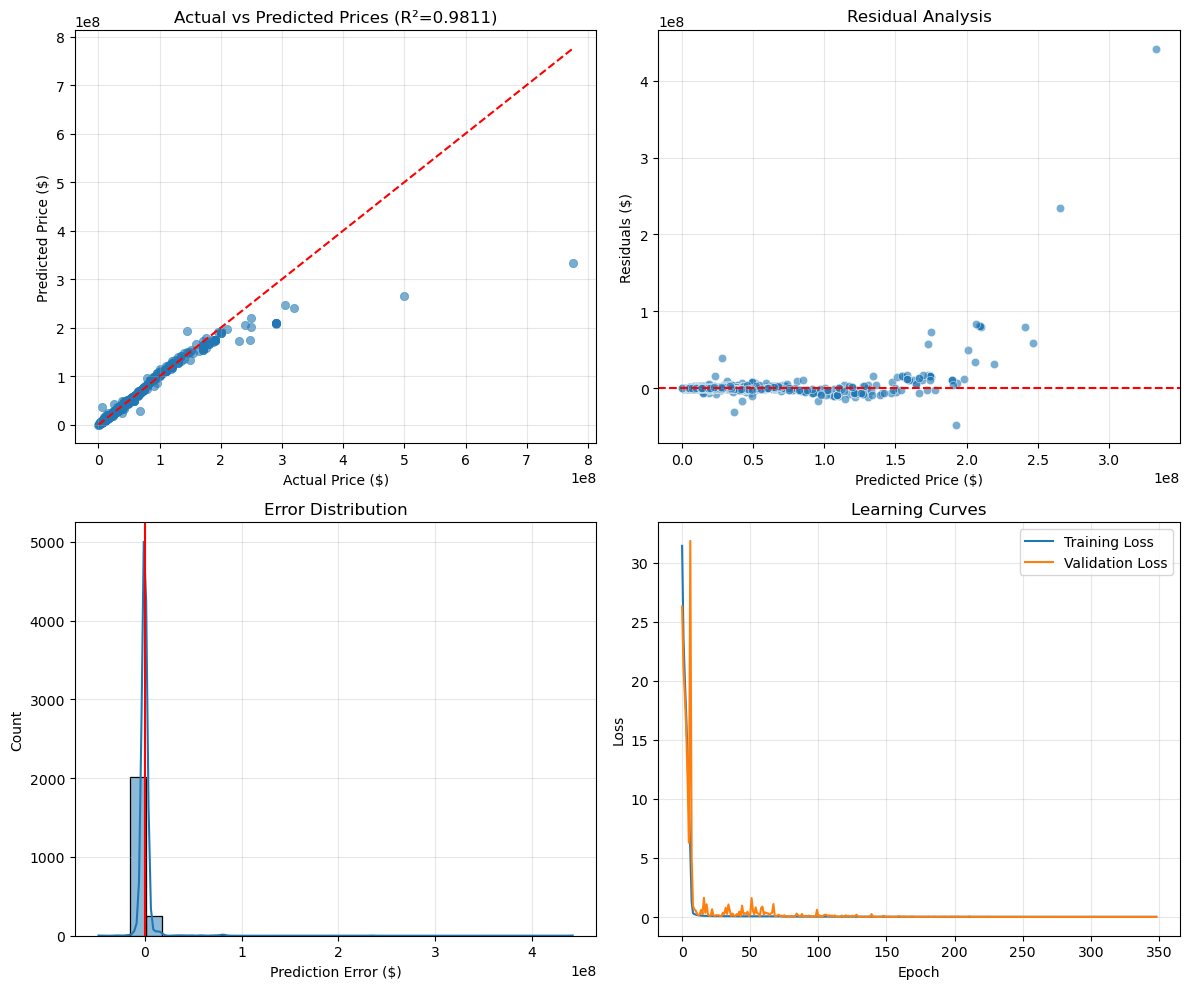

In [49]:
plt.figure(figsize=(12, 10))

#actual vs predicted
plt.subplot(2, 2, 1)
sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred), alpha=0.6, edgecolor=None)
plt.plot([0, max(np.expm1(y_test))], [0, max(np.expm1(y_test))], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Actual vs Predicted Prices (R²={r2:.4f})')
plt.grid(alpha=0.3)

residuals = np.expm1(y_test) - np.expm1(y_pred)
plt.subplot(2, 2, 2)
sns.scatterplot(x=np.expm1(y_pred), y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Analysis')
plt.grid(alpha=0.3)

# error_distribution
plt.subplot(2, 2, 3)
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='-')
plt.xlabel('Prediction Error ($)')
plt.title('Error Distribution')
plt.grid(alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('performance_metrics.png', dpi=300)
plt.show()